In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Process + Save Data

In [72]:
wbt = xr.open_mfdataset('../data/processed/GFDL/WBT/wbt_mean_stull*',combine='nested',concat_dim='ensemble',chunks={'time':1095})
wbt_hist = wbt.sel(time=slice('1980-01-31','1999-12-31')).groupby('time.year').max().mean(['year','ensemble'])
wbt_future = wbt.sel(time=slice('2080-01-31','2099-12-31')).groupby('time.year').max().mean(['year','ensemble'])

In [13]:
tref1 = xr.open_dataset('../data/raw/GFDL/t_ref_mean_1950-2100_ens1-3.nc',chunks={'time':1095})
tref2 = xr.open_mfdataset('/local/ss23/GFDL_LEs/ATM/RCP85/t_ref.rcp85*',combine='nested',concat_dim='ensemble',chunks={'time':1095})
tref = xr.concat([tref1,tref2],dim='ensemble')

In [73]:
tref_hist = tref.sel(time=slice('1980-01-31','1999-12-31')).groupby('time.year').max().mean(['year','ensemble'])
tref_future = tref.sel(time=slice('2080-01-31','2099-12-31')).groupby('time.year').max().mean(['year','ensemble'])

In [74]:
with ProgressBar():
    wbt_hist.to_netcdf('../data/processed/GFDL/Map_Data/wbt_max_1980-2000.nc')
    wbt_future.to_netcdf('../data/processed/GFDL/Map_Data/wbt_max_2080-2100.nc')
    tref_hist.to_netcdf('../data/processed/GFDL/Map_Data/t_ref_max_1980-2000.nc')
    tref_future.to_netcdf('../data/processed/GFDL/Map_Data/t_ref_max_2080-2100.nc')

[########################################] | 100% Completed | 21min 56.7s
[########################################] | 100% Completed | 43min 38.5s
[########################################] | 100% Completed |  2min 31.4s
[########################################] | 100% Completed |  2min 31.9s


# Load Data

In [3]:
wbt_hist = xr.open_dataarray('../data/processed/GFDL/Map_Data/wbt_max_1980-2000.nc')
wbt_future = xr.open_dataarray('../data/processed/GFDL/Map_Data/wbt_max_2080-2100.nc')
tref_hist = xr.open_dataarray('../data/processed/GFDL/Map_Data/t_ref_max_1980-2000.nc') - 273.15
tref_future = xr.open_dataarray('../data/processed/GFDL/Map_Data/t_ref_max_2080-2100.nc') - 273.15

# Plot Maps

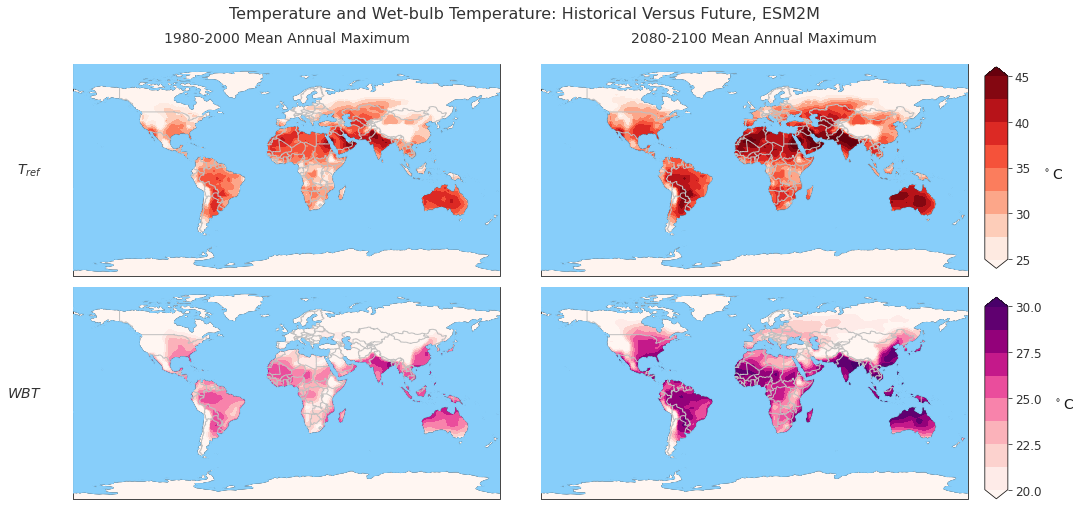

In [4]:
# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(16,8),subplot_kw={'projection':crs},gridspec_kw={'width_ratios': [0.1,3,3]})
levels_temp = np.linspace(25,45,9)
levels_wbt = np.linspace(20,30,9)

im1 = lf.contour(tref_hist,'1980-2000 Mean Annual Maximum\n',axs[0][1],levels=levels_temp,cmap='Reds',label='t_ref',over=None)
lf.contour(tref_future,'2080-2100 Mean Annual Maximum\n',axs[0][2],levels=levels_temp,cmap='Reds',label='t_ref',over=None)

im2 = lf.contour(wbt_hist,None,axs[1][1],levels=levels_wbt,cmap='RdPu',label='Temperature',over=None)
lf.contour(wbt_future,None,axs[1][2],levels=levels_wbt,cmap='RdPu',label='WBT',over=None)

fig.subplots_adjust(right=0.95)
cbar_ax1 = fig.add_axes([0.95, 0.525, 0.02, 0.35])
cbar = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical');
cbar.set_label('\t$^\circ$C',fontsize=14,rotation=0)
cbar.set_ticks(np.linspace(25,45,5))

cbar_ax2 = fig.add_axes([0.95, 0.125, 0.02, 0.35])
cbar = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical');
cbar.set_label('\t$^\circ$C',fontsize=14,rotation=0)
cbar.set_ticks(np.linspace(20,30,5))

# Annotating text
axs[0][0].text(0.5,0.5,'$T_{ref}$',fontsize=14,horizontalalignment='right',verticalalignment='center');
axs[0][0].set_frame_on(False)
axs[1][0].text(0.5,0.5,'$WBT$',fontsize=14,horizontalalignment='right',verticalalignment='center');
axs[1][0].set_frame_on(False)

fig.subplots_adjust(wspace=.02,hspace=.05)
fig.suptitle('Temperature and Wet-bulb Temperature: Historical Versus Future',x=0.55);
fig.savefig('temp_wbt.png', dpi=300)